### Helper functions and imports

In [30]:
!nvidia-smi

Thu May 26 12:25:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:15:00.0  On |                  Off |
| 34%   59C    P2    74W / 260W |   3900MiB / 48578MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:2D:00.0 Off |                  Off |
| 41%   

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random 

# for training on my GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# lambda used later for fitness function
LBD = 0.01

# This module reshapes an input (tensor -> matrix).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size # a list
    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)
# This module flattens an input (matrix -> tensor) by blending dimensions 
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)


# The training procedure
def training(max_patience, num_epochs, model, optimizer, training_loader, val_loader, verbose=False):
    nll_val = []
    error_val = []
    best_nll = 1000.
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train() # set the model to the training mode
    # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # for training on gpu, pass it there
            batch, targets = batch.to(device), targets.to(device)
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        nll_val, error_val = evaluation(val_loader, model_best=model, epoch=e, verbose=verbose)

        if patience > max_patience:
            break

    return nll_val, error_val



def evaluation(test_loader, name=None, model_best=None, epoch=None, verbose = False):
  # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + '.model')
  
    model_best.eval()# set the model to the evaluation mode
    loss_test = 0.
    loss_error = 0.
    N = 0.
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # evalutation on gpu
        test_batch = test_batch.to(device)
        test_targets = test_targets.to(device)
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction='sum')
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        # for evalution on gpu
        y_pred = y_pred.to(device)
        e = 1.*(y_pred == test_targets)
        loss_error = loss_error + (1. - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N
    # Print the performance
    if epoch is None and verbose:
        print(f'-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}')
    else:
        if epoch % 1 == 0 and verbose:
            print(f'Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}')
    return loss_test, loss_error


### Dataset creation

In [2]:
from sklearn.model_selection import train_test_split
import scipy.io
import numpy as np
import torchvision.transforms as Transformer

class Housenumbers(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):       
        # copied from original class, does not have influence on my code.
        self.transforms = transforms 
        
        # pull training data from matlab files using self-made function
        train_pixels, train_targets = self.load_svhn(os.getcwd())
        test_pixels, test_targets = self.load_svhn(os.getcwd(),split='test')
        
        # randomly splitting off validation data used to test performance during training
        # placing randomstate = 42 to ensure that the same set of validation is used 
        # in the case that the class is instantiated several times
        train_pixels, val_pixels, train_targets, val_targets = train_test_split(
                                                            train_pixels,
                                                            train_targets,
                                                            test_size=0.2,
                                                            random_state=42)
        # store training data
        if mode == 'train':
            self.data = train_pixels
            self.targets = train_targets
        # store validation data
        elif mode == 'val':
            self.data = val_pixels
            self.targets = val_targets
        # store testing data
        elif mode == 'test':
            self.data = test_pixels
            self.targets = test_targets
        # catch case that unknown mode has been entered
        else:
            raise Exception('Unkown mode. Cannot create data.')
        print(f'{mode} data created')
        
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)
    
    # function that takes in a dataset in the form of
    # [N, pic_height, pic_width, nr_dim] (numpy format)
    # and returns 
    # [N, nr_dim, pic_height, pic_width] (torch format)
    # additionally, all values are transformed to floats
    def transform_to_torch_tensor(self, dataset):
            # use transformer module as basis for tensor transformation
            transform = Transformer.ToTensor()
            l = [transform(i).float() for i in dataset]
            return torch.stack(l)
    
    # function that reads the training data from the downloaded files
    def load_svhn(self, image_dir, split='train'):
        # depending on the split, open the two different files
        image_file = 'train_32x32.mat' if split=='train' else 'test_32x32.mat'
        image_dir = os.path.join(image_dir, image_file)
        # open file in matlab format
        matlab_labels = scipy.io.loadmat(image_dir)
        # transform to numpy
        labels = matlab_labels['y'].reshape(-1)
        # set labels==10 to labels 0
        labels[np.where(labels==10)] = 0
        # transpose to numpy format
        images_np = np.transpose(matlab_labels['X'], [3, 0, 1, 2]) / 255
        # transpose to torch format -> tensor
        torch_pixels = self.transform_to_torch_tensor(images_np)
        
        return torch_pixels, labels
# create data instances for the different modes used during training and
# testing of the CNN
train_data = Housenumbers(mode='train')
val_data = Housenumbers(mode='val')
test_data = Housenumbers(mode='test')
# load the created datasets into the DataLoader that provides the data
# during both the training as well as the testing process
training_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
print('done')

train data created
val data created
test data created
done


### CNN Class

In [3]:
MAX_WEIGHTS = 3280342 #biggest amount of trainable parameters obtained 
# by calculating the model created by the maximum feature vector ([2,1,0,1,9,0])

# -> training hyperparams
lr = 1e-3 # learning rate
wd = 1e-5 # weight decay
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for 
                  # longer than 20 epochs, it is stopped

In [4]:
class CNN(nn.Module):
    def __init__(self, classnet):
        # init super (parent) class
        super().__init__()
        # import set of layers that was designed
        self.classnet = classnet
        # import loss function
        self.nll = nn.NLLLoss(reduction='none')

    # This function classifies an image x to a class.
    def classify(self, x):
        # based on inputs x, a class prediction y is produced 
        # my multiplying the differnt layers based on the weights
        y_pred = self.classnet(x)
        # get a label in format long from the prediction
        y_preds = torch.tensor([torch.argmax(pred) for pred in y_pred])
        return y_preds # returns label

    # This class outputs a value of the loss function.
    def forward(self, x, y, reduction='avg'):
        # get a label prediction of the set of layers that was created
        y_pred = self.classnet(x)
        # calculate the distance between calculated probabilities y_pred
        # and onehot vector y that encodes the actual label of the picture
        loss = self.nll(y_pred,y)
        if reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()

### Feature Vector Class

This class defines an integer representation in form of a vector. Each position in the vector encodes a different design option for the CNN. This part was created in colaboration with Antoni Stroinski, another AI student.

In [5]:
class FeatureVector():
    def __init__(self, features:list):
        # validate if the feature list is within the legal bounds for the design options
        self.validation(features)
        # maps the design options using a dictionary representation
        mapping = self.mapping()
        self.input_shape = 32
        self.nr_classes = 10
        # all design choices are drawn from the mapping dictionary using the feature vector
        self.nr_filters = mapping['nr_filter'][features[0]] 
        self.conv_options = mapping['conv_options'][features[1]] 
        self.activation_function1 = mapping['activation_function1'][features[2]] 
        self.pooling_layer = mapping['pooling_options']['layer'][features[3]]
        self.pooling_kernel_size = mapping['pooling_options']['kernel_size'][features[3]]
        self.nr_nodes = mapping['nr_nodes'][features[4]] 
        self.activation_function2 = mapping['activation_function2'][features[5]]
        self.list_vec = features

    # method returning a dictionary data structure representing all available design options for the CNN
    def mapping(self):
        return {
            'nr_filter': 
            {
                0:8, 
                1:16,
                2:32
            },
            'conv_options':
            {
                0:{'kernel':(3,3), 'padding':1},
                1:{'kernel':(5,5), 'padding':2}
            },
            'activation_function1':
            {
                0:nn.ReLU(inplace=True),
                1:nn.Sigmoid(),
                2:nn.Tanh(),
                3:nn.Softplus(),
                4:nn.ELU(inplace=True)
            },
            'pooling_options':
            {
                'layer':
                    {
                        0:nn.MaxPool2d(kernel_size=(1,1)),
                        1:nn.AvgPool2d(kernel_size=(1,1)),
                        2:nn.MaxPool2d(kernel_size=(2,2)),
                        3:nn.AvgPool2d(kernel_size=(2,2))
                    },
                'kernel_size':
                    {
                         0:1,
                         1:1,
                         2:2,
                         3:2   
                    }
            },
            'nr_nodes':
            {
                0: 10,
                1: 20,
                2: 30,
                3: 40,
                4: 50,
                5: 60,
                6: 70,
                7: 80,
                8: 90,
                9: 100
            },
            'activation_function2':
            {
                0:nn.ReLU(inplace=True),
                1:nn.Sigmoid(),
                2:nn.Tanh(),
                3:nn.Softplus(),
                4:nn.ELU(inplace=True)
            }
        }

    # creates a Sequential class object by iterating over the list of layers
    def create_sequential(self):
        return nn.Sequential(*[
                                nn.Conv2d(3,self.nr_filters,kernel_size=self.conv_options['kernel'],
                                          padding=self.conv_options['padding']),
                                self.activation_function1,
                                self.pooling_layer,
                                Flatten(),
                                # the number of inputs for the linear layer is dynamic and must be calculated in an extra method
                                nn.Linear(self.calculate_flatten_size(),self.nr_nodes),
                                self.activation_function2,
                                nn.Linear(self.nr_nodes,self.nr_classes),
                                nn.LogSoftmax(dim=1)
                            ])

    # method for calculating number of output features returned from pooling layer
    def calculate_flatten_size(self):
        # formulas taken from pytorch documentation
        conv_out = self.input_shape + 2 *self.conv_options['padding'] -1 * (self.conv_options['kernel'][0] - 1)  -1 + 1
        pooling_out = int(((conv_out + 2 * 0 - 1 * (self.pooling_kernel_size -1) -1)/self.pooling_kernel_size +1)**2*self.nr_filters)
        return pooling_out

    # method to validate if vector within bounds at all indices
    def validation(self, features):
        assert (0 <= features[0] <= 2), features[0]
        assert (0 <= features[1] <= 1), features[1]
        assert (0 <= features[2] <= 4), features[2]
        assert (0 <= features[3] <= 3), features[3]
        assert (0 <= features[4] <= 9), features[4]
        assert (0 <= features[5] <= 4), features[5]

In [6]:
# method returning total number of trainable features of a model
def total_weights(m):
    return sum(i.numel() for i in m.parameters() if i.requires_grad)

In [55]:
total_weights(CNN(FeatureVector([2,1,4,2,9,4]).create_sequential()))

822742

In [54]:
total_weights(CNN(FeatureVector([2,1,2,2,9,4]).create_sequential()))

822742

In [7]:
def test_performance(feature_list, num_epochs = 10, verbose = False):
    # creating a feature vector from a list of features
    vec = FeatureVector(feature_list)
    # creating a nn.Sequential() object based on feature specifications
    classnet = vec.create_sequential()
    # define model based on Sequential() object storing layers
    model = CNN(classnet)
    # sending model data to GPU for faster computation
    model.to(device)
    # initializing the optimizer
    optimizer = torch.optim.Adamax([p for p in model.parameters() 
                                if p.requires_grad == True], lr=lr, weight_decay=wd) 
    # training the model for a number of epochs
    # only the error_val matters in this problem because that is part of the objective function
    _, error_val = training(max_patience=max_patience,
                            num_epochs=num_epochs,
                            model=model,
                            optimizer=optimizer,
                            training_loader=training_loader,
                            val_loader=val_loader,
                            verbose=verbose)
    return error_val, total_weights(model)

In [ ]:
class EA(object):
    def __init__(self,test_performance, pop_size, bounds_min=None, 
                 bounds_max=None, mutation_prob=0.5, num_epochs=1,
                 verbose=False):
        self.verbose = verbose
        # inheriting function for testing CNN performance
        self.test_performance = test_performance
        # hyperparameters for the algorithm
        # pop size must be a round number due to parent recombination method
        assert (pop_size%2==0)
        self.pop_size = pop_size
        self.bounds_min = bounds_min
        self.bounds_max = bounds_max
        self.mutation_prob = mutation_prob
        self.num_epochs = num_epochs
  
    # draws random population, computes opposite population,
    # returns union of both
    # this function returns more individuals than pop_size but in the first
    # parent_selection step, only n=pop_size individuals are drawn, so this 
    # does not matter for later
    def initialize_population(self,optimized=False):
        x = np.random.uniform(low=self.bounds_min, high=self.bounds_max, 
                              size=(self.pop_size, len(self.bounds_min)))
        x = np.round(x)
        if optimized:
            opposite_vectors = []
            for vector in x:
                opposite_vector = self.bounds_max - vector
                opposite_vectors.append(opposite_vector)
            x_proposed = np.concatenate([x,opposite_vectors])
            f_proposed = self.evaluate(x)
            f_indices = f_proposed.argsort()
            x_sorted = x_proposed[f_indices]
            f_sorted = f_proposed[f_indices]
            x = x_sorted[:self.pop_size]
            f = f_sorted[:self.pop_size]
            return x, f
        elif not optimized:
            f = self.evaluate(x)
            return x, f
        else:
            raise Exception('optimized flag must be True or False.')

    # selecting the n=pop_size best parents for offspring generation
    def parent_selection(self, x_old, f_old):
        f_inds = f_old.argsort()
        x_old = x_old[f_inds]
        f_old = f_old[f_inds]
        x_parents = x_old[:self.pop_size]
        f_parents = f_old[:self.pop_size]
        return x_parents, f_parents
    
    # recombining parental genomes for offspring generation
    # genes from two iteratively selected similarly performing parents are 
    # combined and crossover is performed at random locations
    # forming two genotypes as a result
    def recombination(self, x_parents, f_parents):
        if self.verbose:
            print('recombination: parents',x_parents)
        children = []
        for i in range(0,self.pop_size,2):
            cross_over = np.random.randint(0,len(x_parents[i]))
            child1 = x_parents[i][:cross_over].tolist()
            child1.extend(x_parents[i+1][cross_over:].tolist())
            child2 = x_parents[i+1][:cross_over].tolist()
            child2.extend(x_parents[i][cross_over:].tolist())
            children.append(child1)
            children.append(child2)
        x_children = np.array(children)
        x_children = np.rint(x_children)
        if self.verbose:
            print('to children ', x_children,'\n')
        return x_children
    
    # function mutating children with p=mutation_prob
    # if child is selected for mutation, a random gene is randomly 
    # altered to a new value within the bounds
    def mutation(self, x_children):
        if self.verbose:
            print('mutation',x_children)
        new_children = []
        for child in x_children:
            if np.random.uniform() > self.mutation_prob:
                mutate = random.choice([0,1,2,3,4,5])
                new_value = random.choice(range(bounds_min[mutate],bounds_max[mutate]+1))
                child[mutate] = new_value
            new_children.append(child)
        new_children = np.asarray(new_children)
        new_children = np.rint(new_children)
        if self.verbose:
            print('new chilren', new_children, '\n')
        return new_children

    # n=pop_size survivors are selected based on performance
    def survivor_selection(self, x_old, x_children, f_old, f_children):
        x = np.concatenate([x_old, x_children])
        f = np.concatenate([f_old, f_children])
        f_inds = f.argsort()
        x = x[f_inds]
        f = f[f_inds]
        x = x[:self.pop_size]
        f = f[:self.pop_size]
        return x, f

    # performance of genotype (representing CNN structures) are evaluated based on training performance
    # after n=num_epochs number of epochs
    def evaluate(self, x):
        performances = []
        for i,feature_vec in enumerate(x):
            ce, total_weights = self.test_performance(feature_vec,num_epochs = self.num_epochs)
            objective = ce + LBD * total_weights / MAX_WEIGHTS
            performances.append(objective)
        return np.asarray(performances)
  
    # step function defining how a step in the EA is calculated
    def step(self, x_old, f_old):
        # selecting parents for offspring generation
        x_parents, f_parents = self.parent_selection(x_old, f_old)
        # recombining parental genotypes for offspring generation
        x_children = self.recombination(x_parents, f_parents)
        # mutating genotypes of children
        x_children = self.mutation(x_children)
        # calculating performance of children
        f_children = self.evaluate(x_children)
        # selecting survivors based on elitism
        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)
        return x, f

In [38]:
# if file already exists, overwrite content otherwise create new file
def log_file_creation(path:str) -> str:
    if os.path.exists(path):
        open(path, 'w').close()
    else:
        open(path, 'a').close()
    # returns file path for convenience
    return path

In [42]:
# calculating the processing time out of interest
from datetime import datetime
start = datetime.now()

# initializing hyperparameters
pop_size = 10
bounds_min = [0,0,0,0,0,0]
bounds_max = [2,1,4,3,9,4]
num_generations = 50
mutation_prob = 0.6
num_epochs = 3
optimized_population_initialization = True
ea_verbose = False

# file name for result writing during training on GPU because output is silent by necessity
file_name = log_file_creation('results_final.txt')

# initializing the EA algorithm
ea = EA(test_performance, pop_size, bounds_min=bounds_min, bounds_max=bounds_max, num_epochs=num_epochs,verbose=ea_verbose)

# initializing the population (union of random and opposite positions in random)
# see elaboration of this method in the paper
x, f = ea.initialize_population(optimized=optimized_population_initialization)

# print(x)
# print(f)

# overwriting lists from last run of the EA
f_best = None
x_best = None

# store best performing genotype and fitness in lists
f_best = [f.min()]
x_best = [x[np.where(f == f.min())]]

# Run the EA for a number of generations
for i in range(num_generations):
    # do one step
    x, f = ea.step(x, f)
    for j in range(len(x)):
        print(x[j],f[j])
    # if a new minimum has been found
    if f.min() < f_best[-1]:
        # append that minimum and its genotype
        f_best.append(f.min())
        x_best.append(x[np.where(f == f.min())])
    else: # reappend the old minimum and its genotype
        f_best.append(f_best[-1])
        x_best.append(x_best[-1])
    # write results to file
    with open(file_name,'a') as file:
        best_vec = list(map(round,x_best[-1][0]))
        file.write(f'Generation: {i}\tbest fitness: {f.min():.6f}\tbest vector: {best_vec}\n')
    print('Generation: {}, best fitness: {:.2f}'.format(i, f.min()))

# store final results in variables for later analysis
final_vec = FeatureVector(best_vec)

# write EA-generated CNN architecture to file
with open(file_name,'a') as file:
    print('final CNN structure:\n',final_vec.create_sequential(),file=file)
    print(f'Total time of computing: {datetime.now() - start}.',file=file)
print('FINISHED!')

[1. 1. 2. 3. 7. 4.] 0.1829101829101829
[2. 1. 4. 1. 8. 3.] 0.1844799344799345
[1. 1. 4. 1. 6. 3.] 0.1947174447174447
[1. 1. 2. 3. 8. 3.] 0.19512694512694512
[2. 1. 4. 1. 7. 0.] 0.20816270816270815
[1. 0. 0. 0. 9. 1.] 0.21212121212121213
[1. 0. 0. 0. 9. 0.] 0.21867321867321868
[1. 0. 2. 3. 9. 0.] 0.23887523887523887
[1. 1. 4. 1. 6. 1.] 0.3026208026208026
[1. 0. 2. 3. 9. 1.] 0.32903357903357905
Generation: 0, best fitness: 0.18
[1. 1. 2. 2. 8. 3.] 0.17294567294567295
[1. 1. 2. 3. 7. 4.] 0.1829101829101829
[2. 1. 4. 1. 8. 3.] 0.1844799344799345
[0. 1. 4. 1. 7. 4.] 0.1855036855036855
[1. 1. 2. 3. 8. 3.] 0.18857493857493857
[1. 1. 4. 1. 6. 3.] 0.1947174447174447
[1. 1. 2. 3. 8. 3.] 0.19512694512694512
[1. 1. 4. 1. 6. 3.] 0.19812994812994814
[2. 1. 0. 0. 9. 1.] 0.20017745017745017
[2. 1. 4. 1. 7. 0.] 0.20816270816270815
Generation: 1, best fitness: 0.17
[1. 1. 2. 2. 8. 3.] 0.17294567294567295
[1. 1. 4. 1. 8. 3.] 0.1773136773136773
[1. 1. 2. 3. 7. 4.] 0.1829101829101829
[2. 1. 4. 1. 8. 3.] 0.

### Evaluation of the finally generated CNN architecture

Epoch: 0, val nll=0.8032045957334635, val ce=0.23634998634998636
Epoch: 5, val nll=0.4843323455786334, val ce=0.13247338247338247
Epoch: 10, val nll=0.4987864180272504, val ce=0.1317908817908818
Epoch: 15, val nll=0.524846283498762, val ce=0.13527163527163527
Epoch: 20, val nll=0.5490436263579734, val ce=0.12974337974337974
Epoch: 25, val nll=0.5683637124217016, val ce=0.128992628992629
Epoch: 30, val nll=0.6083648572878013, val ce=0.12933387933387933
-> FINAL PERFORMANCE: nll=0.8144579999522061, ce=0.15165949600491702


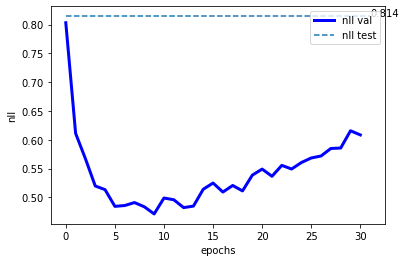

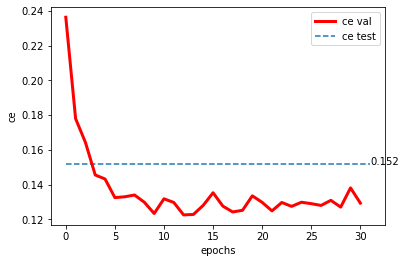

In [51]:
def final_evaluation(test_loader, model, name=None, epoch=None):
    # set model to evaluation mode
    model.eval()
    loss_test = 0.
    loss_error = 0.
    N = 0.
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # send data to GPU for faster calculations
        test_batch, test_targets =test_batch.to(device), test_targets.to(device)
        # calculate batch of loss values based on testing data
        loss_test_batch = model.forward(test_batch, test_targets, reduction='sum')
        loss_test = loss_test + loss_test_batch.item()
        # predict class labels based on network features
        y_pred = model.classify(test_batch)
        # send data to GPU for faster calculation
        y_pred = y_pred.to(device)
        e = 1.*(y_pred == test_targets)
        loss_error = loss_error + (1. - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N
    # Print the performance
    if epoch is None:
        print(f'-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}')
    else:
        if epoch % 5 == 0:
            print(f'Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}')
    return loss_test, loss_error

def final_training(max_patience, num_epochs, best_vec, training_loader, val_loader):
    # based on the best found feature vector from the EA, define a fresh model for training
    vec = FeatureVector(best_vec)
    # create nn.Sequential() with embedded design choices
    classnet = vec.create_sequential()
    # create model from layer object
    model = CNN(classnet)
    # send model to GPU
    model.to(device)
    # initialize the optimizer
    optimizer = torch.optim.Adamax([p for p in model.parameters() 
                                    if p.requires_grad == True], lr=lr, weight_decay=wd) 
    # create list of negative log loss and classification error for plotting over time
    nll_val = []
    error_val = []
    best_nll = 1000.
    patience = 0
    # iterate over trainging epochs
    for e in range(num_epochs):
        # set model to training mode
        model.train()
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # send data to GPU for faster calculation
            batch = batch.to(device)
            targets = targets.to(device)
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()
        # return the final evaluation
        loss_e, error_e = final_evaluation(val_loader, model=model, epoch=e)
        # save for plotting
        nll_val.append(loss_e)  
        # save for plotting
        error_val.append(error_e)
        # save inital model
        if e == 0:
            torch.save(model, 'final.model')
            best_nll = loss_e
        # in later iterations
        else:
            # if there is a new best model found
            if loss_e < best_nll:
                torch.save(model, 'final.model')
                best_nll = loss_e
                patience = 0
            else: # if there is no new best model found, wait longer
                patience = patience + 1
        # if no new model was found for a certain nr of generations, break the training loop
        if patience > max_patience:
            break

    # Return nll and classification error arrays for plotting
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)
    return nll_val, error_val, model

def plot_curve(name, signal, xlabel='epochs', ylabel='nll', \
               color='b-', test_eval=None):
    # plot the curve
    plt.plot(np.arange(len(signal)), signal, color, linewidth='3', label=ylabel +' val')
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(test_eval, xmin=0, xmax=len(signal), linestyles='dashed', label=ylabel\
               +' test')
        plt.text(len(signal), test_eval, "{:.3f}".format(test_eval),)
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.show()
def final_pipeline(final_vec,num_epochs):
    nll_val, error_val, trained_model = final_training(best_vec=final_vec.list_vec,
                                                max_patience=max_patience,
                                                num_epochs=num_epochs,
                                                training_loader=training_loader,
                                                val_loader=val_loader)
    test_loss, test_error = final_evaluation(model=trained_model, test_loader=test_loader)
    plot_curve('final.model', nll_val, ylabel='nll', test_eval=test_loss)
    plot_curve('final.model', error_val, ylabel='ce', color='r-', test_eval=test_error)
final_pipeline(final_vec=FeatureVector([2,1,4,2,9,4]),num_epochs=50)